In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping

from isic_helper import DotDict
from isic_helper import get_folds
from isic_helper import compute_auc, compute_pauc

pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "lgb_v3"

In [3]:
INPUT_PATH = Path("../input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False)
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv")

folds_df = get_folds()
train_metadata = train_metadata.merge(folds_df, on=["isic_id", "patient_id"], how="inner")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

Train data size: (401059, 57)
Test data size: (3, 44)


In [4]:
id_column = "isic_id"
target_column = "final_target"
group_column = "patient_id"

In [5]:
def count_features(df, col):
    tmp = df[[id_column, group_column, col]].pivot_table(
        values=id_column, 
        index=group_column, 
        columns=col, 
        aggfunc="count", 
        fill_value=0)
#     tmp = tmp / tmp.sum(axis=0)
    feature_cols = tmp.columns.tolist()
    tmp.reset_index(inplace=True)
    tmp.index.name = None
    df = df.merge(tmp, on=group_column, how="left")
    return df, feature_cols


def stat_features(df, group_cols, value_col, stats):
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    df[f"{value_col}_mean_diff"] = df[value_col] - df[f"{value_col}_mean"]
    return df


def feature_engineering(df):
    new_num_cols = []
    
#     df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
#     df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
#     df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
#     df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
#     df["max_minus_min_lesion_size"] = df["clin_size_long_diam_mm"] - df["tbp_lv_minorAxisMM"]
#     new_num_cols += ["lesion_size_ratio", "hue_contrast", "normalized_lesion_size", "overall_color_difference", "max_minus_min_lesion_size"]
    
    df, feature_cols = count_features(df, "anatom_site_general")
    new_num_cols += feature_cols
    
    df["tbp_lv_A_diff"] =  df["tbp_lv_Aext"] - df["tbp_lv_A"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_A_diff", ["mean"])
    new_num_cols += ["tbp_lv_A_diff_mean_diff"]
    
    df["tbp_lv_B_diff"] =  df["tbp_lv_Bext"] - df["tbp_lv_B"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_B_diff", ["mean"])
    new_num_cols += ["tbp_lv_B_diff_mean_diff"]
    
    df["tbp_lv_L_diff"] =  df["tbp_lv_Lext"] - df["tbp_lv_L"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_L_diff", ["mean"])
    new_num_cols += ["tbp_lv_L_diff_mean_diff"]
    
    df["tbp_lv_L_std_diff"] =  df["tbp_lv_stdLExt"] - df["tbp_lv_stdL"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_L_std_diff", ["mean"])
    new_num_cols += ["tbp_lv_L_std_diff_mean_diff"]
    
    return df, new_num_cols

train_metadata, new_num_cols = feature_engineering(train_metadata.copy())
test_metadata, _ = feature_engineering(test_metadata.copy())

In [6]:
ord_categorical_features = [
#     "sex", 
#     "anatom_site_general", 
    "tbp_tile_type", 
    "tbp_lv_location", 
#     "tbp_lv_location_simple",
    "attribution", "copyright_license"
]
ohe_categorical_features = []
numerical_features = [
    "age_approx", 
    "clin_size_long_diam_mm",
    "tbp_lv_A", "tbp_lv_Aext",
    "tbp_lv_B", "tbp_lv_Bext",
    "tbp_lv_C", "tbp_lv_Cext",
    "tbp_lv_H", "tbp_lv_Hext",
    "tbp_lv_L", "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border", "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL", "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
    "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
]
numerical_features += new_num_cols

In [7]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [8]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata["fold"]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

print(f"Total number of columns: {len(X_train.columns)}")

Total number of columns: 47


In [9]:
def pauc_80(preds, data):
    score_value = compute_pauc(data.get_label(), preds, min_tpr=0.8)   
    return 'pauc_80', score_value, True


params = {
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 63,
    "learning_rate": 0.01,
    "bagging_freq": 5,
    "bagging_fraction": 0.6,
    "bagging_seed": cfg.seed,
    "feature_fraction": 0.3,
    "feature_fraction_seed": cfg.seed,
    "lambda_l1": 0.95,
    "lambda_l2": 0.95,
    "verbosity": -1
}
num_rounds = 2500
es_rounds = 250
log_rounds = 50

In [10]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.sort(folds.unique())
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
#     if fold != 4:
#         continue
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    lgb_dataset_dev = lgb.Dataset(X_dev, label=y_dev, categorical_feature=categorical_features, free_raw_data=False)
    lgb_dataset_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(
        params,
        lgb_dataset_dev,
        num_boost_round=num_rounds,
        valid_sets=[lgb_dataset_val],
        feval=pauc_80,
        callbacks=[early_stopping(stopping_rounds=es_rounds), log_evaluation(log_rounds)],
    )
    
    model.save_model(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    best_num_rounds[f"fold_{fold}"] = model.best_iteration
    val_scores = dict(model.best_score["valid_0"])
    
    val_auc_scores[f"fold_{fold}"] = val_scores["auc"]
    val_pauc_scores[f"fold_{fold}"] = val_scores["pauc_80"]
    
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    oof_predictions[val_index] = val_preds
    print("\n")

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(X_train.columns)

Running fold: 1
Training until validation scores don't improve for 250 rounds
[50]	valid_0's auc: 0.938496	valid_0's pauc_80: 0.154459
[100]	valid_0's auc: 0.941212	valid_0's pauc_80: 0.155507
[150]	valid_0's auc: 0.941949	valid_0's pauc_80: 0.155512
[200]	valid_0's auc: 0.943713	valid_0's pauc_80: 0.156822
[250]	valid_0's auc: 0.945983	valid_0's pauc_80: 0.158389
[300]	valid_0's auc: 0.948346	valid_0's pauc_80: 0.160546
[350]	valid_0's auc: 0.949688	valid_0's pauc_80: 0.16176
[400]	valid_0's auc: 0.950547	valid_0's pauc_80: 0.162443
[450]	valid_0's auc: 0.951593	valid_0's pauc_80: 0.163259
[500]	valid_0's auc: 0.953186	valid_0's pauc_80: 0.164773
[550]	valid_0's auc: 0.95385	valid_0's pauc_80: 0.165189
[600]	valid_0's auc: 0.954101	valid_0's pauc_80: 0.165185
[650]	valid_0's auc: 0.954544	valid_0's pauc_80: 0.165615
[700]	valid_0's auc: 0.955122	valid_0's pauc_80: 0.165997
[750]	valid_0's auc: 0.955066	valid_0's pauc_80: 0.165802
[800]	valid_0's auc: 0.955225	valid_0's pauc_80: 0.1659

<Axes: >

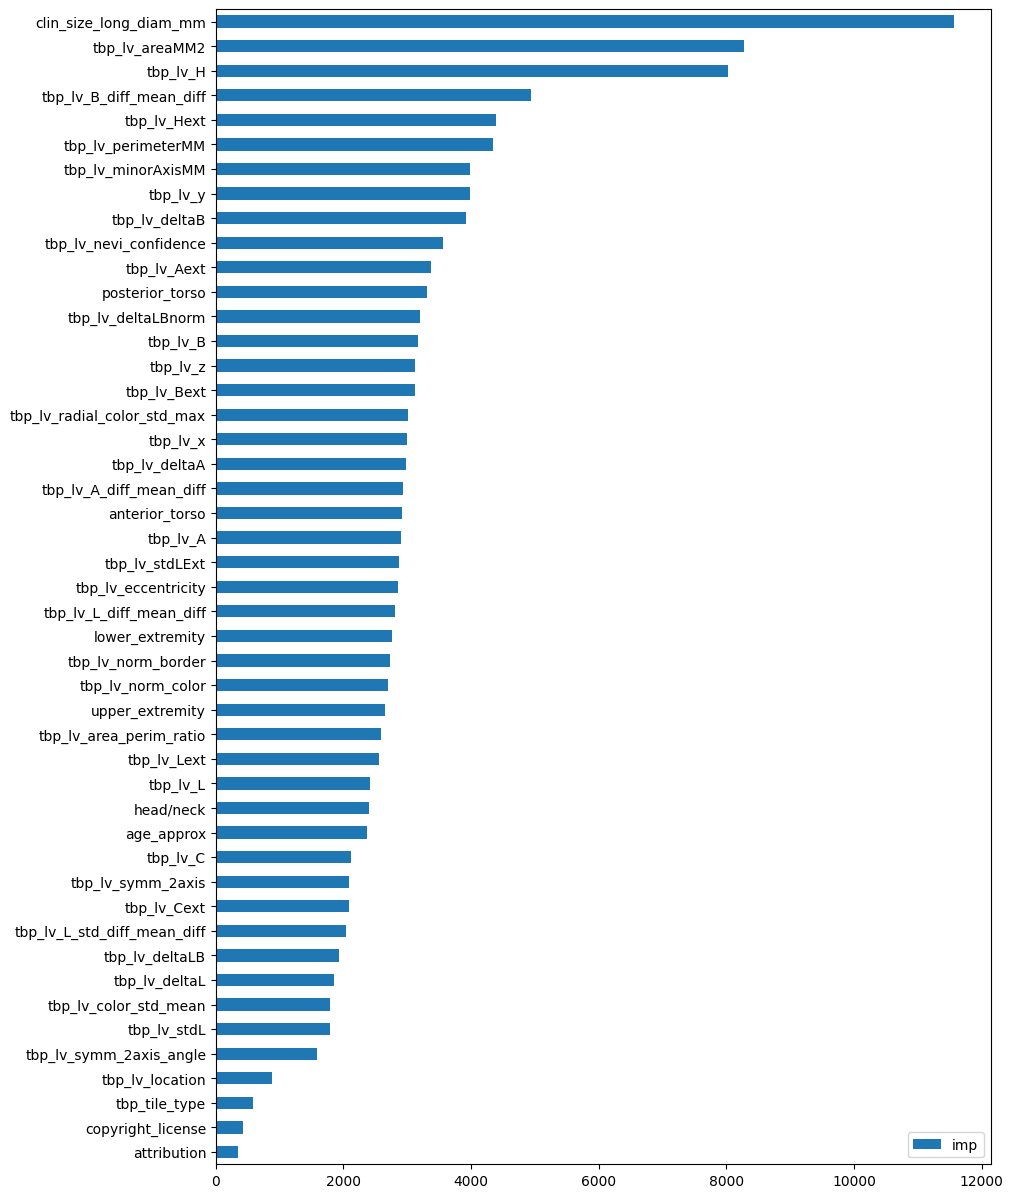

In [11]:
feature_importances = 0
for fold in all_folds:
    model = lgb.Booster(model_file=MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    if fold == 1:
        feature_names = model.feature_name()
    feature_importances += model.feature_importance(importance_type="gain")
feature_importances /= len(all_folds)

imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 15))

In [12]:
metadata = {
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)